# 3D House project

This project consists of plotting an interactive 3D Surface Graph of a house, based on the address provided. The region covered is the region of Flanders (Belgium).

The data are *Lidar* data. The region is divided into 43 rasters. Each raster is in the format **.tif** . This program will select the correct raster after getting from an API the geospatial coordinates corresponding to the address of the house.

## 1. Libraries

In [16]:
import geopandas as gpd
from shapely.geometry import Polygon

import rasterio # Tif files
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
#import rioxarray as rxr
from rasterio.plot import show
from rasterio.mask import mask

import requests
import json

## 2. Address and coordinates

In [60]:
post_code = int(input("Post code: "))

Post code:  3020


In [61]:
street_name = input("Street name: ")

Street name:  Lodewijk van Veltemstraat


In [62]:
house_number = int(input("House number: "))

House number:  15


In [63]:
# Address request to the basisregisters Vlaanderen API

# HTTP request to the API
address = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",
                      params={'postcode': post_code, 'straatnaam': street_name, 'huisnummer':house_number})

address = address.json() # Convert http request's response into json format

In [115]:
def get_coordinates(address):
    """
    Function that get the geospatial coordinates and separate the latitude and longitude
    in two different lists (lat, lon).
    """

    address = address['adresMatches'][0]
    
    norm = pd.json_normalize(address)
    norm = norm.loc[0,'adresseerbareObjecten']
    block_url = norm[0].get('detail')
    block_url
    
    # Second request
    address = requests.get(block_url)
    block_details = address.json()
    block_details
    
    building = block_details.get('gebouw')
    url_house = building.get('detail')
    
    # Third request
    house = requests.get(url_house)
    house_details = house.json()


    df = pd.json_normalize(house_details) # Convert the json format into a Pandas DataFrame
    
    house_coordinates = df.loc[0,'geometriePolygoon.polygon.coordinates']
    lat_lon = []

    # Write geometry coordinates to a list
    for list in house_coordinates:
        for sublist in list:
            for coordinates in sublist:
                print(coordinates, end='\n')
                lat_lon.append(coordinates)

    lat = []
    lon = []

    for i, coords in enumerate(lat_lon):
        if i % 2 == 0:
            lat.append(coords)
        else:
            lon.append(coords)

    return lat, lon

In [65]:
lat, lon = get_coordinates(address)

167710.48200749606
176747.95897277445
167701.10703148693
176745.50201277435
167700.8360554874
176745.43097277358
167703.8909034878
176733.7705567628
167708.84271149337
176735.0441567637
167709.482583493
176731.938748762
167714.3252074942
176733.29465276375
167710.48200749606
176747.95897277445


## 3. Creation of the polygon

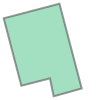

In [66]:
polygon_geometry = Polygon(zip(lat, lon)) # Geometry
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geometry])

polygon_geometry

## 4. Selection of the raster

All the rasters are located in the local drive and separated in two distincts folders (/DSM and /DTM)

In [67]:
def select_raster(coordinates):
    """
    Function that select the correct raster based on the coordinates of the address.
    """
    
    df = pd.read_csv('rasters_lambert_coordinates.csv') # Load the csv file
    

    # Search for the correct raster
    raster = df[(df['Left'] < coordinates[0]) & (df['Right'] > coordinates[0])
       & ((df['Bottom'] < coordinates[1]) & (df['Top'] > coordinates[1]))]
    
    num_raster = raster['Raster'].item() # Raster number
    
    return num_raster

In [68]:
# Return raster number
raster_number = select_raster([lat[0],lon[0]])

## 5. Masking the DSM and DTM

In [81]:
path_DSM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k{raster_number}.tif"  
path_DTM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DTM/DHMVIIDTMRAS1m_k{raster_number}.tif"
path_DSM

# Open DTM and DSM rasters
raster_DTM = rasterio.open(path_DTM)
raster_DSM = rasterio.open(path_DSM)


# Crop of the DTM raster based on the polygon geometry
masked_DTM, masked_transform_DTM = mask(dataset=raster_DTM, shapes=polygon.geometry, crop=True, filled=False) 


# Crop of the DSM raster based on the polygon geometry
masked_DSM, masked_transform_DSM = mask(dataset=raster_DSM, shapes=polygon.geometry, crop=True, filled=False) 

profile = raster_DTM.meta.copy()

width = masked_DTM.shape[2]
height = masked_DTM.shape[1]
profile.update(drivers='GTiff', transform=masked_transform_DTM, height=height, width=width)

print(profile)

# Create a new file "masked_DSM.tif" and saving it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DSM.tif", 'w', **profile) as dst:
    dst.write(masked_DSM) 
    
# Create a new file "masked_DTM.tif" and saving it into the local drive    
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DTM.tif", 'w', **profile) as dst:
    dst.write(masked_DTM) # Save the masked DTM

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 15, 'height': 17, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 167700.0,
       0.0, -1.0, 176748.0), 'drivers': 'GTiff'}


## 6. Creation of the CHM (Canopy Height Model)

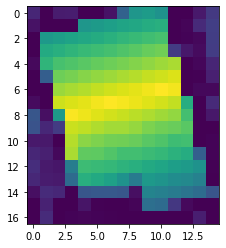

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 15, 'height': 17, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 167700.0,
       0.0, -1.0, 176748.0), 'drivers': 'GTiff'}


In [99]:
m_DTM = rasterio.open('masked_DTM.tif')
m_DSM = rasterio.open('masked_DSM.tif')

DSM_array = m_DSM.read(1)
DTM_array = m_DTM.read(1)
raster_CHM = DSM_array - DTM_array # Canopy Height Model (CHM) = (DSM - DTM)
show(raster_CHM)

print(profile)

# # Create a new file "CHM.tif" and save it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/CHM.tif", 'w', **profile) as dst:
    dst.write(raster_CHM, 1)

## 7. 3D Plot

The library used is **plotly**. The 3D Surface plot opens in the browser in a new tab.

In [111]:
CHM = rasterio.open('CHM.tif')
CHM_array = CHM.read(1) # Convert the raster into a Numpy array

"""import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
init_notebook_mode()
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from plotly.offline import init_notebook_mode, iplot"""

from plotly.graph_objs import *
fig = go.Figure(data=[go.Surface(z=CHM_array)]) # Create the figure from the CHM array
fig.write_image("image.png") # Write image to the local drive

plot(fig) # Plot the house in new tab

'temp-plot.html'